# Project 4: Football matches as mobility networks
During a football match, players move on the field to attack and defend. This generates a series of movements that can be analyzed to understand the players behavior.<br><br>
The student should use the `Wyscout open dataset`, describing the “events” in all matches of seven competitions (e.g., passes, shots, tackles etc.), to analyze pass chains and the mobility of football players. A player’s movement is defined by consecutive events made by that player in the match.<br><br>
- Investigate the distances traveled by players during their matches and their distributions. Discuss about the similarity of these distributions with those about mobility trajectories seen during the course.<br><br>
- Relate the pass chains made by teams with the probability of making a shot, a goal, and to win a match. Are long chains more likely to lead to a shot/goal? Are short pass chains more successful?<br><br>
- Quantify the predictability of pass chains based on some division of the football field (tessellation). To what extent can we predict the next tile (field zone) where the ball will be? Use a next-location predictor to quantify the accuracy to predict the next zone the ball will be.

In [1]:
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *

import warnings
warnings.filterwarnings('ignore')

## Utils functions

In [2]:
def extract_teams(teams_df, type, area=""):
    if type == 'club':
        return teams_df[(teams_df['area'] == area) & (teams_df['type'] == 'club')]
    elif type == 'national':
        return teams_df[(teams_df['type'] == 'national')]

In [3]:
def prepare_teams(teams_df):
    teams_df['area'] = teams_df['area'].apply(lambda x: x.get('name'))
    return teams_df

In [4]:
def extract_events(events_df, area):
    events = events_df[area][events_df[area]['playerId'] != 0]
    return events

In [5]:
def prepare_events(events):
    events['x'] = events['positions'].apply(lambda x: x[0]['x'])
    events['y'] = events['positions'].apply(lambda x: x[0]['y'])
    events.drop(columns={'id', 'subEventName', 'positions', 'eventName'}, inplace=True)
    return events

In [6]:
def extract_role(role):
    return role.get('code2')

In [7]:
def prepare_players(players_df):
    players_df['role'] = players_df['role'].apply(extract_role)
    players_df.drop(columns={'passportArea','weight','height','foot','birthArea','birthDate','middleName','firstName','lastName', 'currentNationalTeamId', 'shortName', 'currentTeamId'},inplace=True)
    players_df.rename(columns={'wyId':'playerId'}, inplace=True)
    return players_df

In [8]:
def compute_distance(df):
    # Sort the dataframe by playerId, matchId, matchPeriod, gameweek, and eventSec
    df.sort_values(by=['matchId', 'playerId', 'matchPeriod', 'eventSec'], inplace=True)

    # Compute the distance between consecutive points
    df['distance'] = np.sqrt(((df.groupby(['matchId', 'playerId', 'matchPeriod'])['x'].diff()**2) + (df.groupby(['playerId', 'matchId', 'matchPeriod'])['y'].diff()**2)))

    # Fill NaN values with 0
    df['distance'].fillna(0, inplace=True)
    
    return df

In [9]:
def sum_distances(df):
    tmp_df = df.groupby(['playerId', 'matchId'])['distance'].sum()
    tmp_df = round(tmp_df, -2)
    return pd.DataFrame(tmp_df)

In [10]:
def count_distances(df):
    # Count the occurrences of each unique distance value
    distance_counts = df['distance'].value_counts().reset_index()

    # Sort the DataFrame by distance
    distance_counts = distance_counts.sort_values(by='distance')

    distance_counts['distance'] = distance_counts['distance'].astype(int)

    return distance_counts

In [11]:
def plot_histogram(df):
    plt.figure(figsize=(15, 6))
    sns.barplot(data=df, x='distance', y='count', color='skyblue')
    plt.xlabel('Distance')
    plt.ylabel('Count')
    plt.title('Count of Distances')
    plt.xticks(rotation=45)
    plt.show()

In [12]:
def group_by_distance_role(df):
    # Count the occurrences of each unique distance value
    distance_counts_by_role = df[['distance', 'role']].value_counts().reset_index()

    # Sort the DataFrame by distance
    distance_counts_by_role = distance_counts_by_role.sort_values(by='distance')

    distance_counts_by_role['distance'] = distance_counts_by_role['distance'].astype(int)

    return distance_counts_by_role

In [13]:
def plot_histogram_per_role(df):
    plt.figure(figsize=(25, 6))
    sns.barplot(data=df, x='distance', y='count', hue='role')
    plt.xlabel('Distance')
    plt.ylabel('Count')
    plt.title('Histogram of Distances by Role')
    plt.legend(title='Role')
    plt.xticks(rotation=45)
    plt.show()

### Data load

In [14]:
# loading the events data
events={}
nations = ['Italy','England','Germany','France','Spain','European_Championship','World_Cup']
for nation in nations:
    with open('./data/events/events_%s.json' %nation) as json_data:
        events[nation] = json.load(json_data)
        
# loading the match data
matches={}
for nation in nations:
    with open('./data/matches/matches_%s.json' %nation) as json_data:
        matches[nation] = json.load(json_data)

# loading the players data
players={}
with open('./data/players.json') as json_data:
    players = json.load(json_data)

# loading the competitions data
competitions={}
with open('./data/competitions.json') as json_data:
    competitions = json.load(json_data)

# loading the teams data
teams={}
with open('./data/teams.json') as json_data:
    teams = json.load(json_data)

### JSON to DataFrame

In [15]:
teams_df = pd.DataFrame(teams)
players_df = pd.DataFrame(players)
competitions_df = pd.DataFrame(competitions)
matches_df = {
    'Italy': pd.DataFrame(matches['Italy']),
    'England': pd.DataFrame(matches['England']),
    'Germany': pd.DataFrame(matches['Germany']),
    'France': pd.DataFrame(matches['France']),
    'Spain': pd.DataFrame(matches['Spain']),
    'European_Championship': pd.DataFrame(matches['European_Championship']),
    'World_Cup': pd.DataFrame(matches['World_Cup'])
}
events_df = {
    'Italy': pd.DataFrame(events['Italy']),
    'England': pd.DataFrame(events['England']),
    'Germany': pd.DataFrame(events['Germany']),
    'France': pd.DataFrame(events['France']),
    'Spain': pd.DataFrame(events['Spain']),
    'European_Championship': pd.DataFrame(events['European_Championship']),
    'World_Cup': pd.DataFrame(events['World_Cup'])
}

### Some data preparation

In [16]:
players_df = prepare_players(players_df)

In [17]:
teams_df = prepare_teams(teams_df)

## Italian first division analysis

In [19]:
italian_events_df = prepare_events(extract_events(events_df, 'Italy'))

In [20]:
events_players_df = pd.merge(italian_events_df, players_df, on='playerId', how='left')

In [21]:
events_players_distances_df = compute_distance(events_players_df)

In [22]:
italian_tmp_df = sum_distances(events_players_distances_df)

In [23]:
distances_count = count_distances(italian_tmp_df)

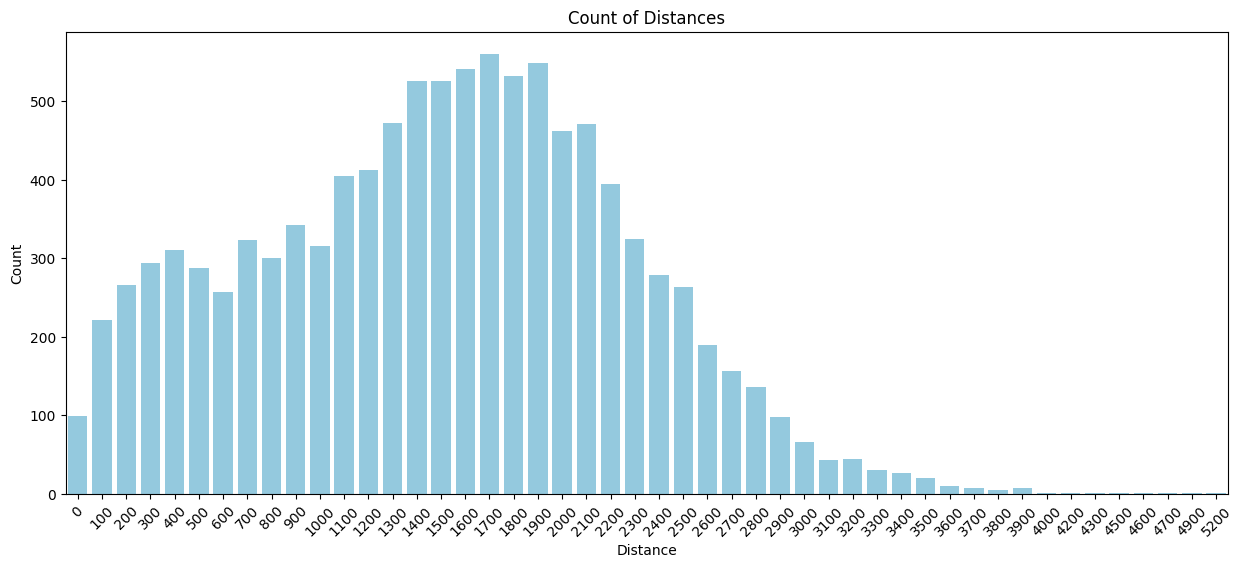

In [24]:
plot_histogram(distances_count)

In [25]:
italian_players_role_distances_df = pd.merge(italian_tmp_df, players_df, on='playerId', how='left')

In [26]:
players_role_distances_df = group_by_distance_role(italian_players_role_distances_df)

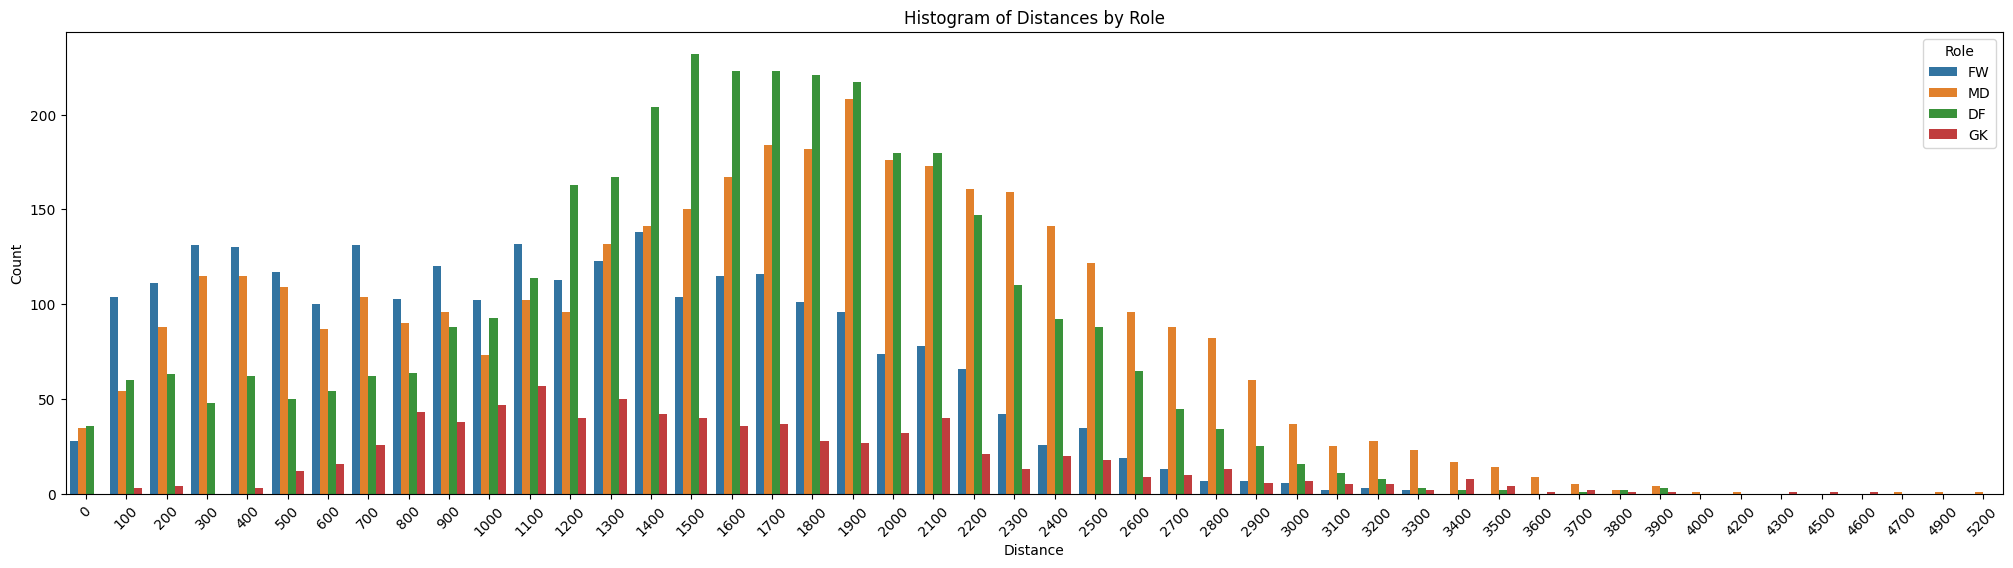

In [27]:
plot_histogram_per_role(players_role_distances_df)

## English first division analysis

In [28]:
english_events_df = prepare_events(extract_events(events_df, 'England'))

In [29]:
events_players_df = pd.merge(english_events_df, players_df, on='playerId', how='left')

In [30]:
events_players_distances_df = compute_distance(events_players_df)

In [31]:
english_tmp_df = sum_distances(events_players_distances_df)

In [32]:
distances_count = count_distances(english_tmp_df)

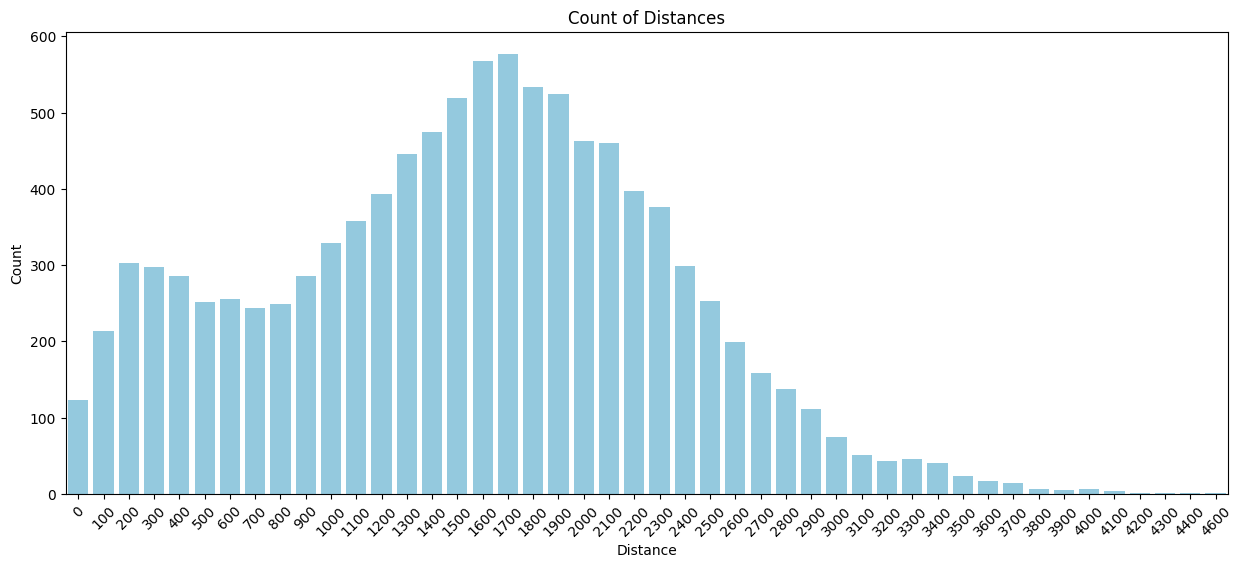

In [33]:
plot_histogram(distances_count)

In [34]:
english_players_role_distances_df = pd.merge(english_tmp_df, players_df, on='playerId', how='left')

In [35]:
players_role_distances_df = group_by_distance_role(english_players_role_distances_df)

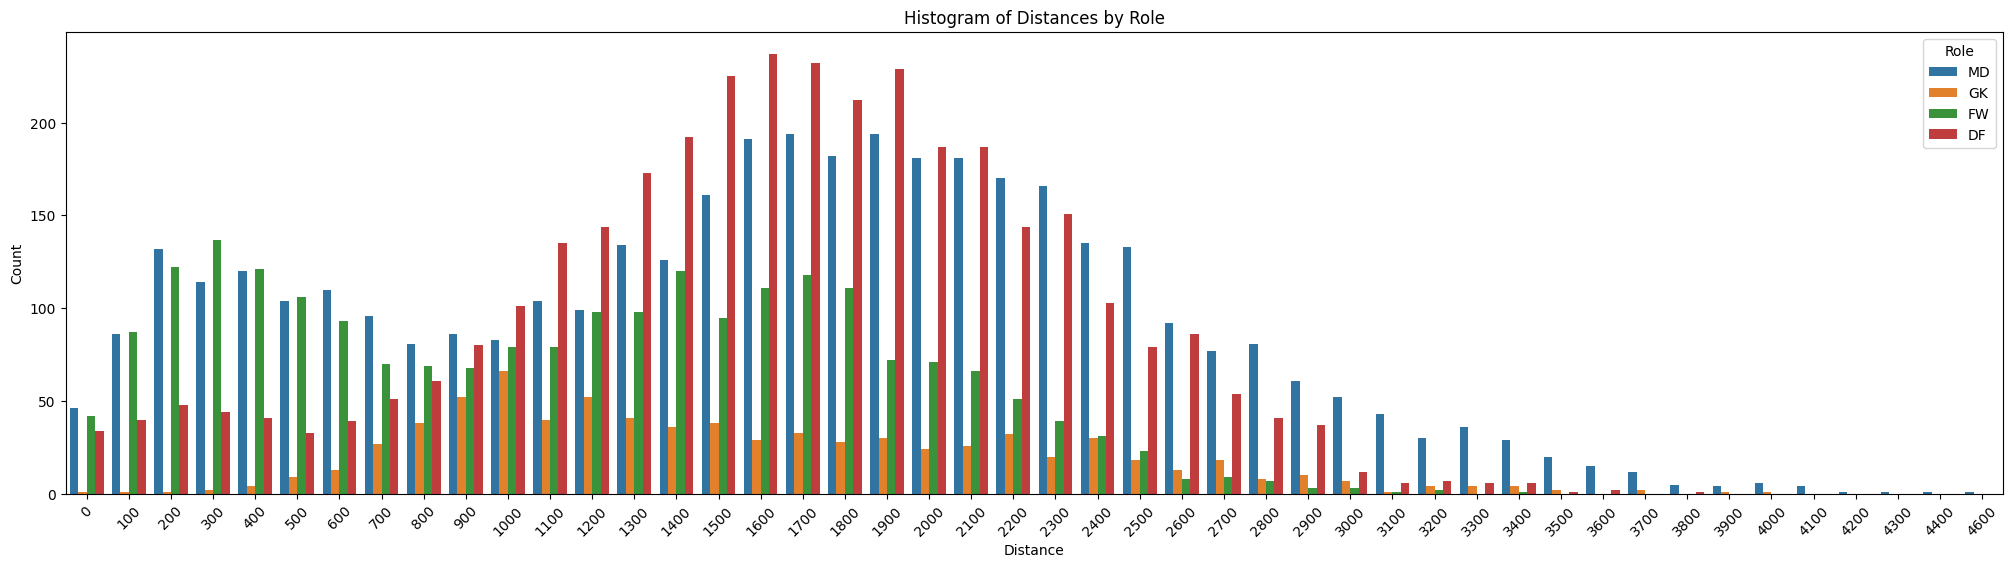

In [36]:
plot_histogram_per_role(players_role_distances_df)

## Spanish first division analysis

In [37]:
spanish_events_df = prepare_events(extract_events(events_df, 'Spain'))

In [38]:
events_players_df = pd.merge(spanish_events_df, players_df, on='playerId', how='left')

In [39]:
events_players_distances_df = compute_distance(events_players_df)

In [40]:
spanish_tmp_df = sum_distances(events_players_distances_df)

In [41]:
distances_count = count_distances(spanish_tmp_df)

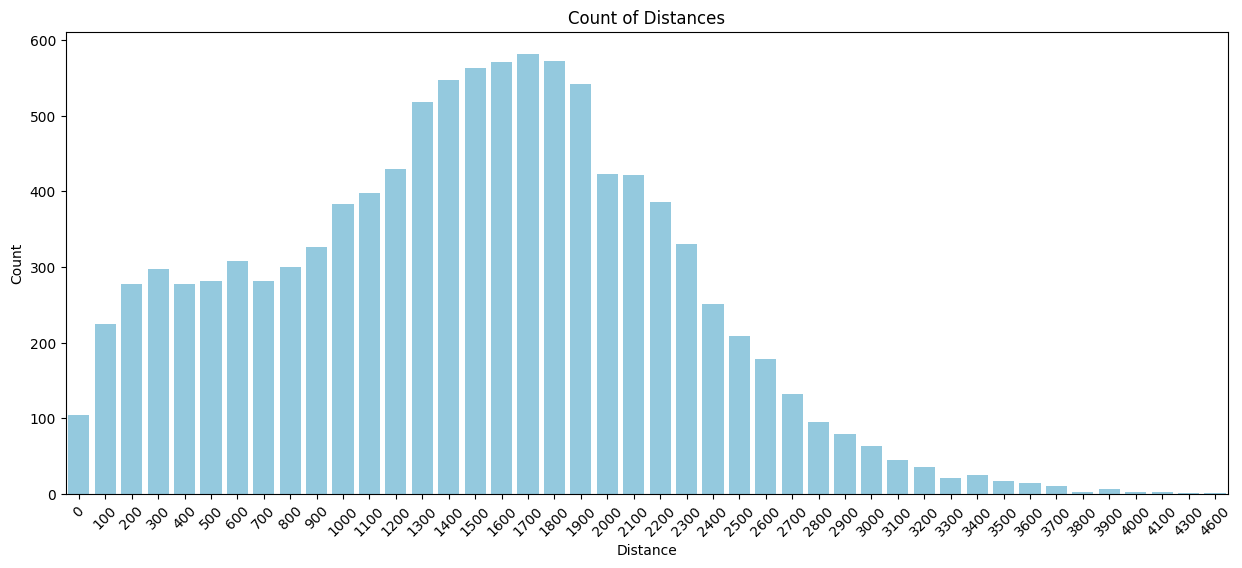

In [42]:
plot_histogram(distances_count)

In [43]:
spanish_players_role_distances_df = pd.merge(spanish_tmp_df, players_df, on='playerId', how='left')

In [44]:
players_role_distances_df = group_by_distance_role(spanish_players_role_distances_df)

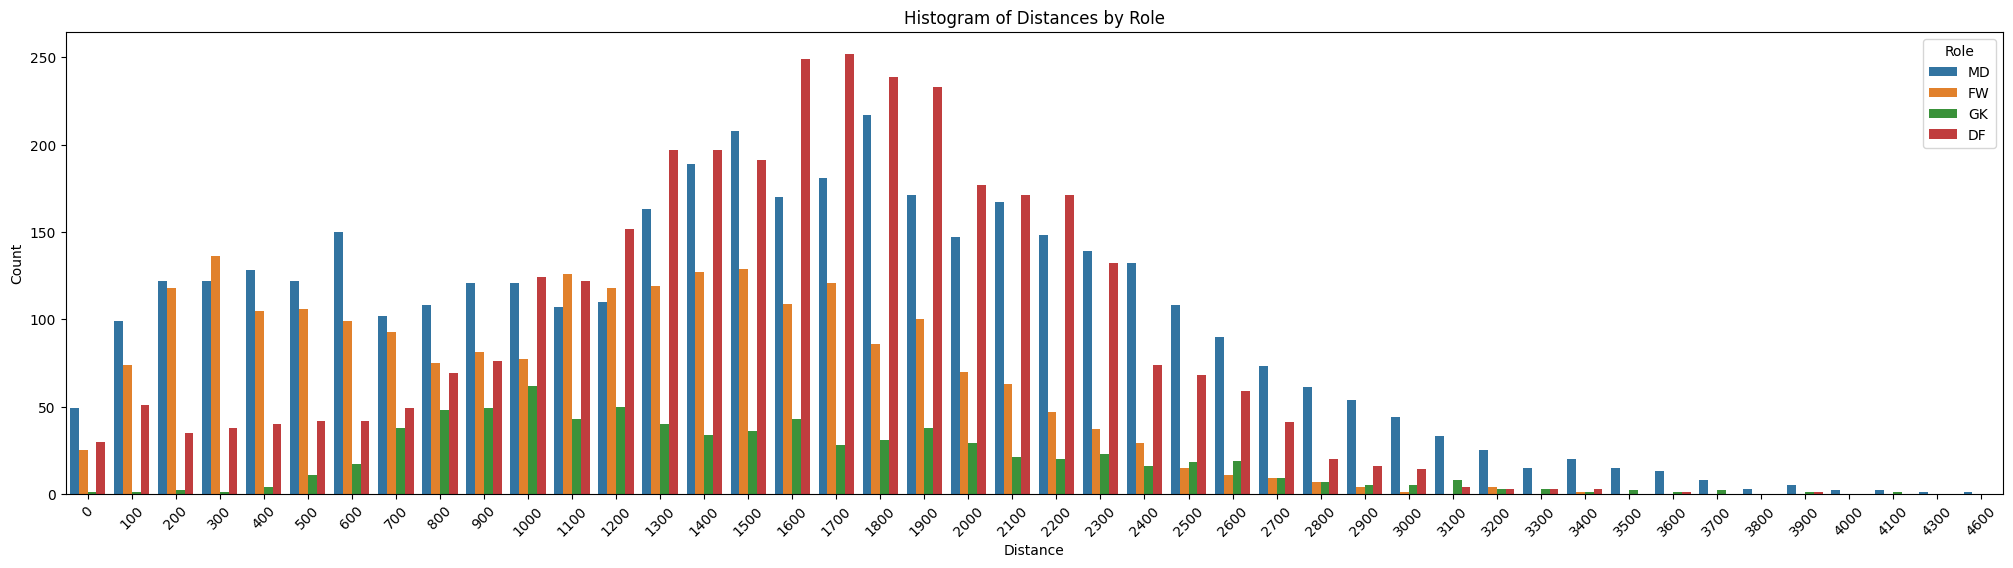

In [45]:
plot_histogram_per_role(players_role_distances_df)

## German first division analysis

In [46]:
german_events_df = prepare_events(extract_events(events_df, 'Germany'))

In [47]:
events_players_df = pd.merge(german_events_df, players_df, on='playerId', how='left')

In [48]:
events_players_distances_df = compute_distance(events_players_df)

In [49]:
german_tmp_df = sum_distances(events_players_distances_df)

In [50]:
distances_count = count_distances(german_tmp_df)

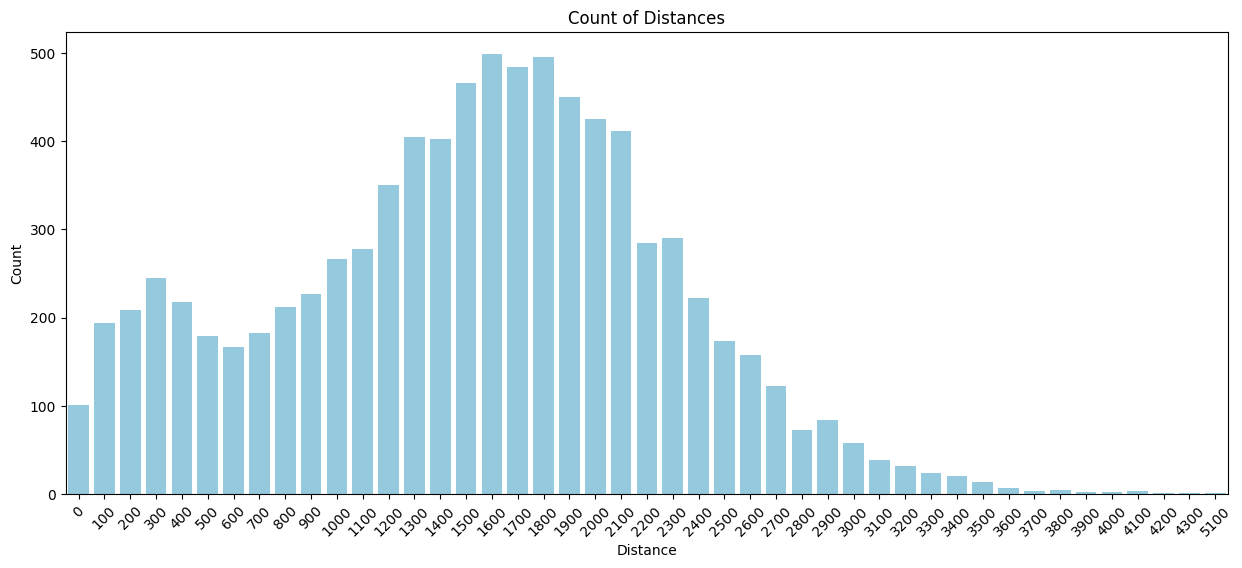

In [51]:
plot_histogram(distances_count)

In [52]:
german_players_role_distances_df = pd.merge(german_tmp_df, players_df, on='playerId', how='left')

In [53]:
players_role_distances_df = group_by_distance_role(german_players_role_distances_df)

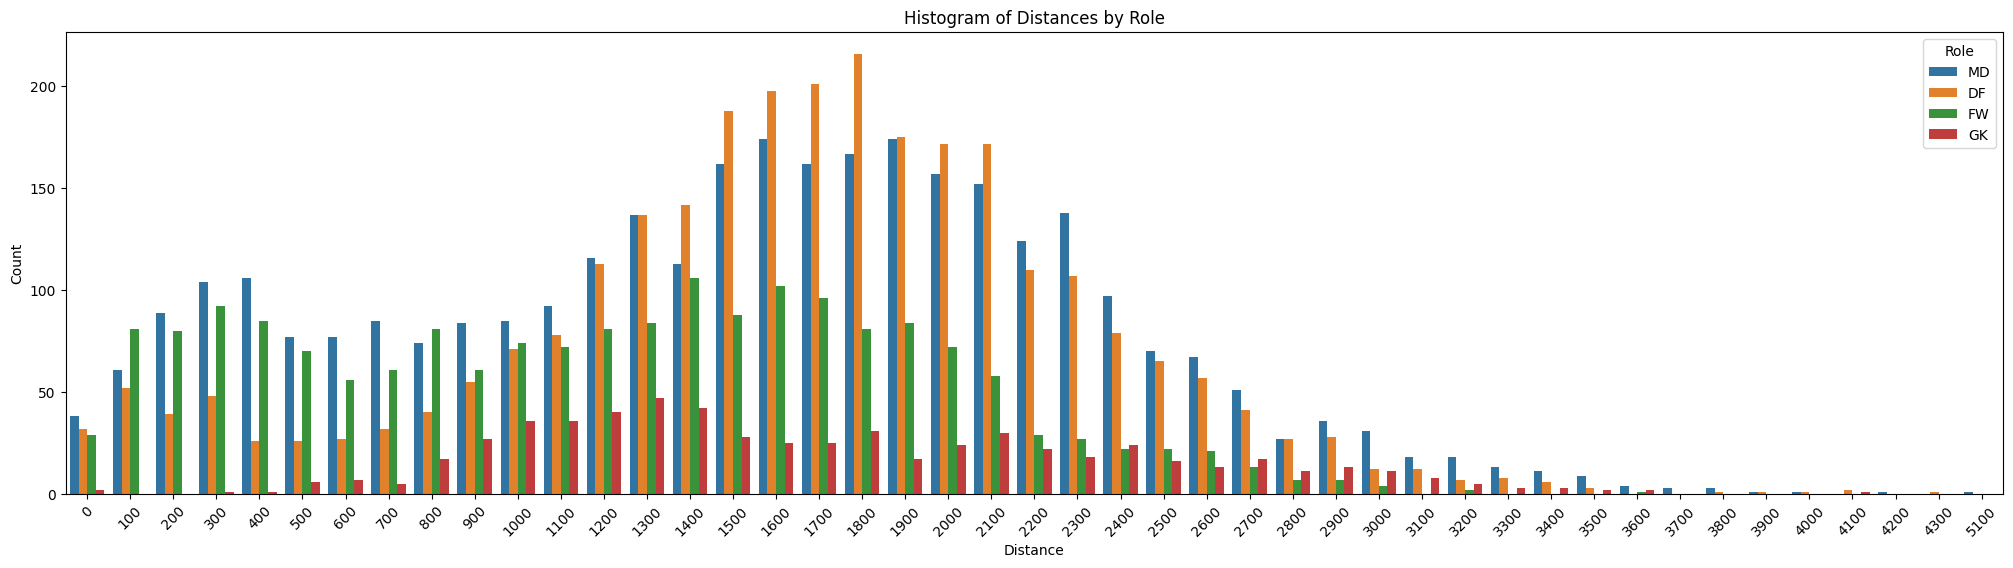

In [54]:
plot_histogram_per_role(players_role_distances_df)

## French first division analysis

In [55]:
french_events_df = prepare_events(extract_events(events_df, 'France'))

In [56]:
events_players_df = pd.merge(french_events_df, players_df, on='playerId', how='left')

In [57]:
events_players_distances_df = compute_distance(events_players_df)

In [58]:
french_tmp_df = sum_distances(events_players_distances_df)

In [59]:
distances_count = count_distances(french_tmp_df)

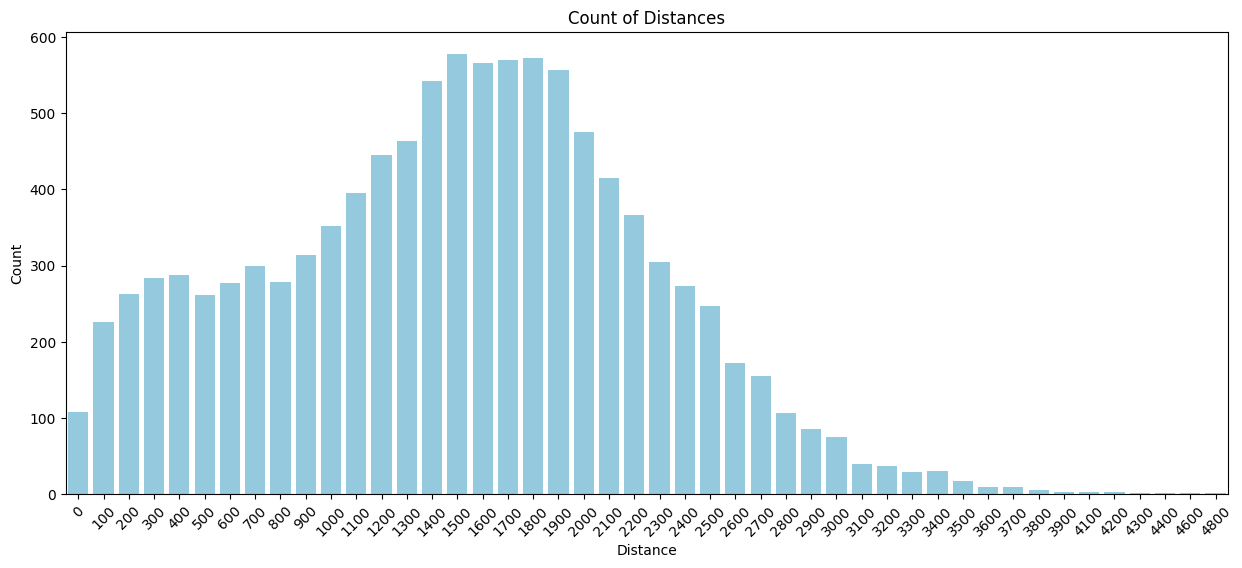

In [60]:
plot_histogram(distances_count)

In [61]:
french_players_role_distances_df = pd.merge(french_tmp_df, players_df, on='playerId', how='left')

In [62]:
players_role_distances_df = group_by_distance_role(french_players_role_distances_df)

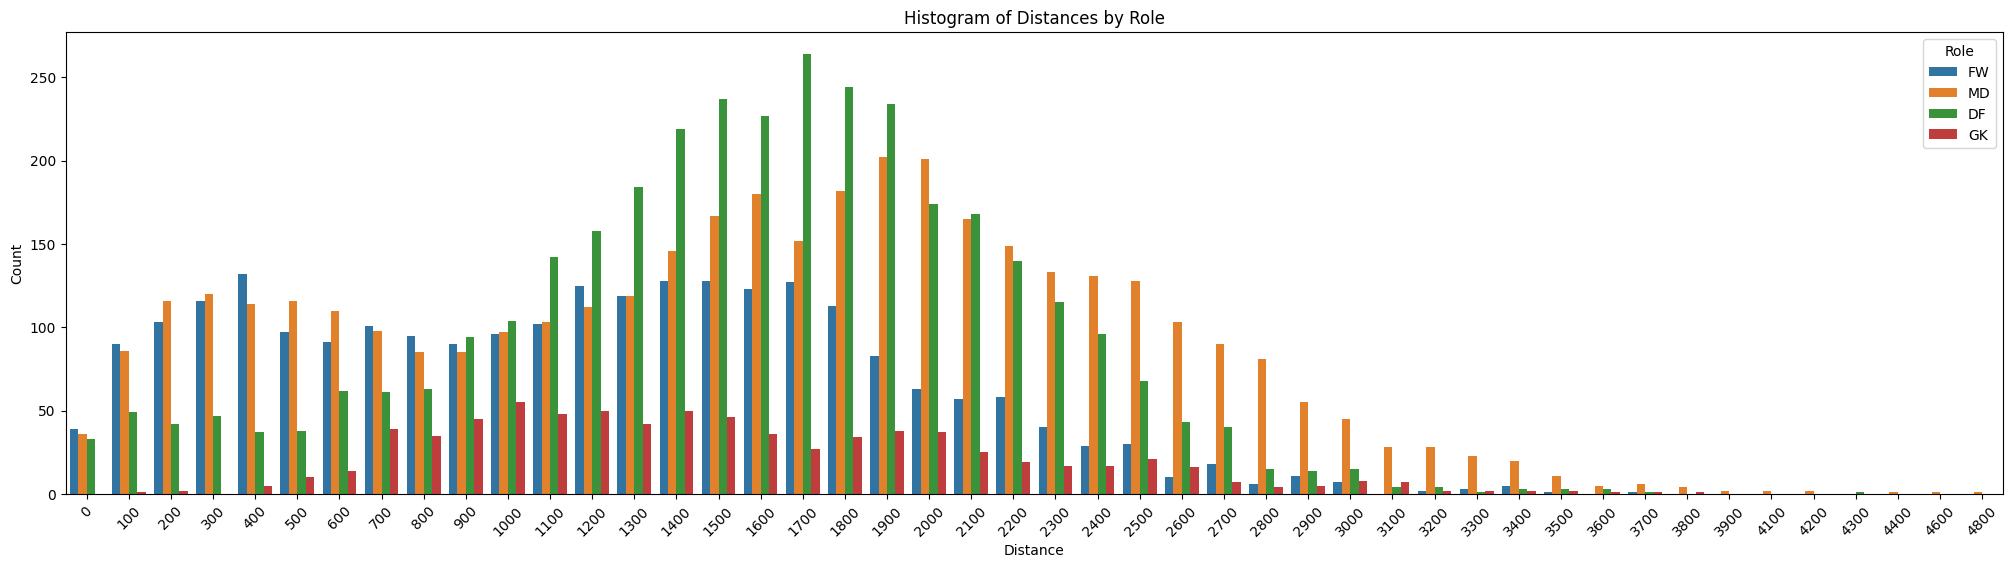

In [63]:
plot_histogram_per_role(players_role_distances_df)

## European Championship

In [64]:
european_events_df = prepare_events(extract_events(events_df, 'European_Championship'))

In [65]:
events_players_df = pd.merge(european_events_df, players_df, on='playerId', how='left')

In [66]:
events_players_distances_df = compute_distance(events_players_df)

In [67]:
european_tmp_df = sum_distances(events_players_distances_df)

In [68]:
distances_count = count_distances(european_tmp_df)

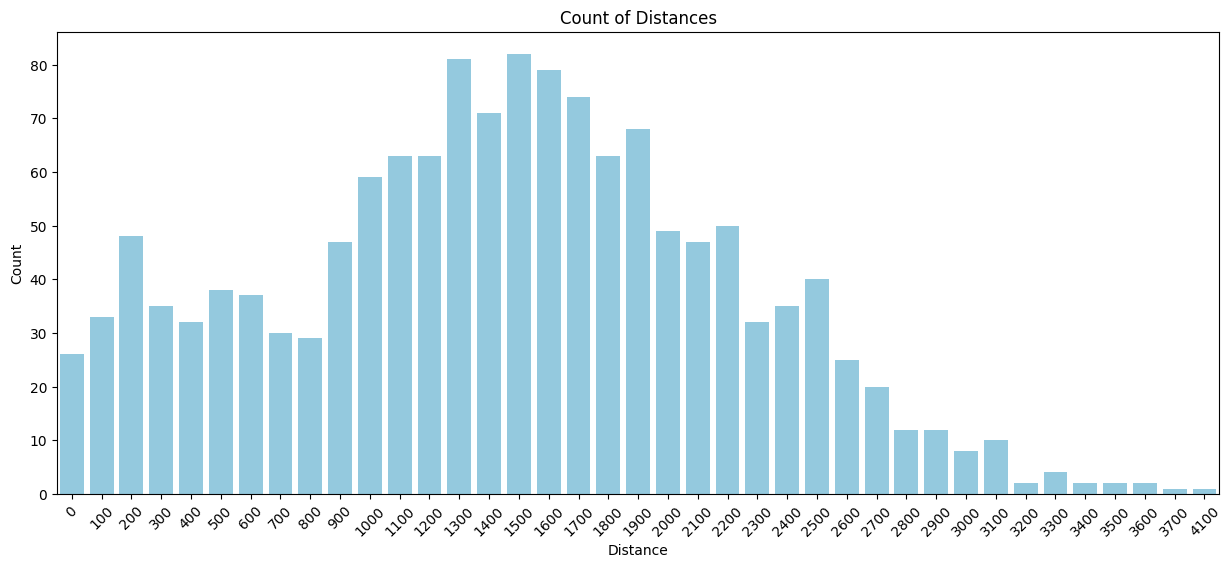

In [69]:
plot_histogram(distances_count)

In [70]:
european_players_role_distances_df = pd.merge(european_tmp_df, players_df, on='playerId', how='left')

In [71]:
players_role_distances_df = group_by_distance_role(european_players_role_distances_df)

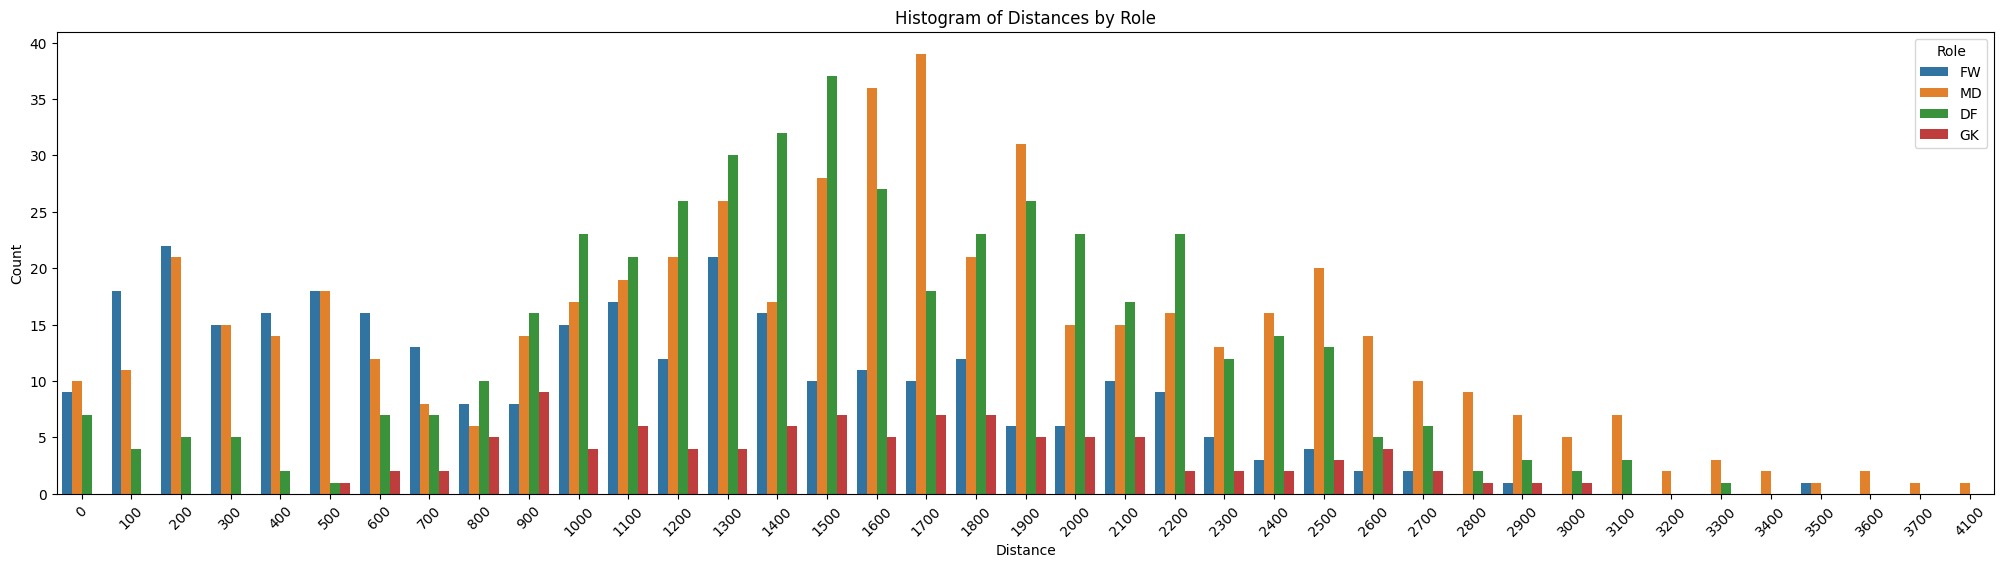

In [72]:
plot_histogram_per_role(players_role_distances_df)

## World Cup

In [73]:
world_events_df = prepare_events(extract_events(events_df, 'World_Cup'))

In [74]:
events_players_df = pd.merge(world_events_df, players_df, on='playerId', how='left')

In [75]:
events_players_distances_df = compute_distance(events_players_df)

In [76]:
world_tmp_df = sum_distances(events_players_distances_df)

In [77]:
distances_count = count_distances(world_tmp_df)

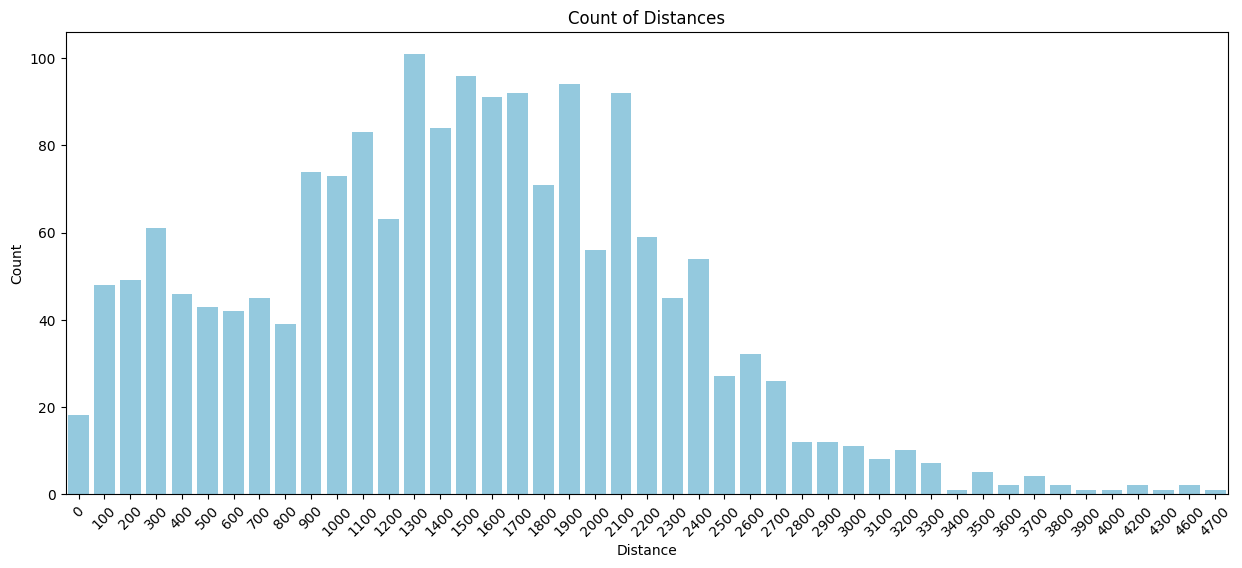

In [78]:
plot_histogram(distances_count)

In [79]:
world_players_role_distances_df = pd.merge(world_tmp_df, players_df, on='playerId', how='left')

In [80]:
players_role_distances_df = group_by_distance_role(world_players_role_distances_df)

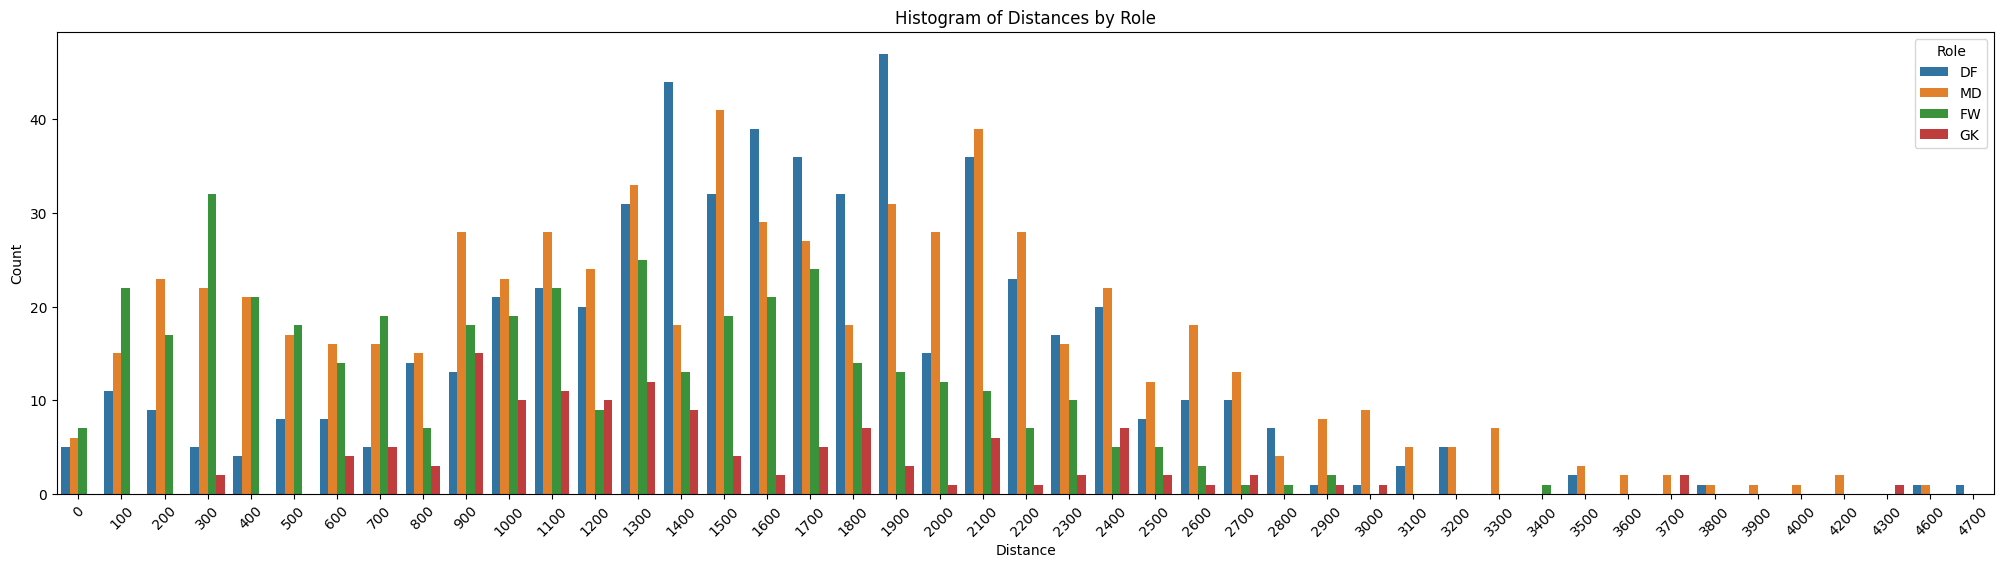

In [81]:
plot_histogram_per_role(players_role_distances_df)

### Total distances

In [82]:
total_tmp_df = pd.concat([italian_tmp_df, english_tmp_df, spanish_tmp_df, german_tmp_df, french_tmp_df, european_tmp_df, world_tmp_df])

In [83]:
distances_count = count_distances(total_tmp_df)

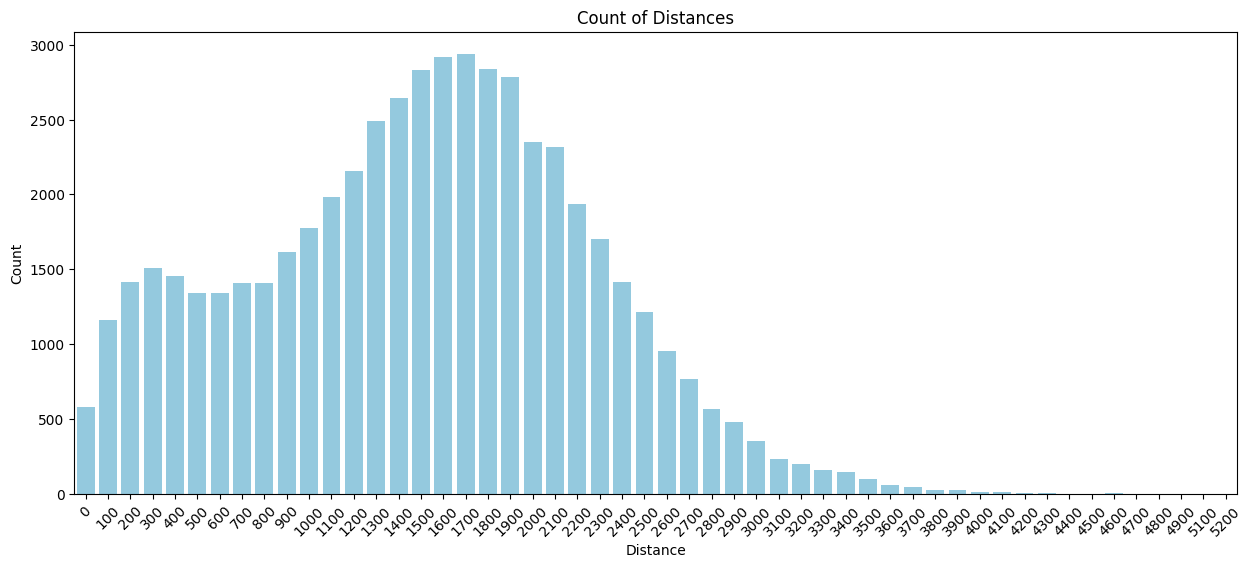

In [84]:
plot_histogram(distances_count)

In [85]:
total_player_role_df = pd.concat([italian_players_role_distances_df, english_players_role_distances_df, spanish_players_role_distances_df,
                                  german_players_role_distances_df, french_players_role_distances_df, european_players_role_distances_df,
                                  world_players_role_distances_df])

In [86]:
players_role_distances_df = group_by_distance_role(total_player_role_df)

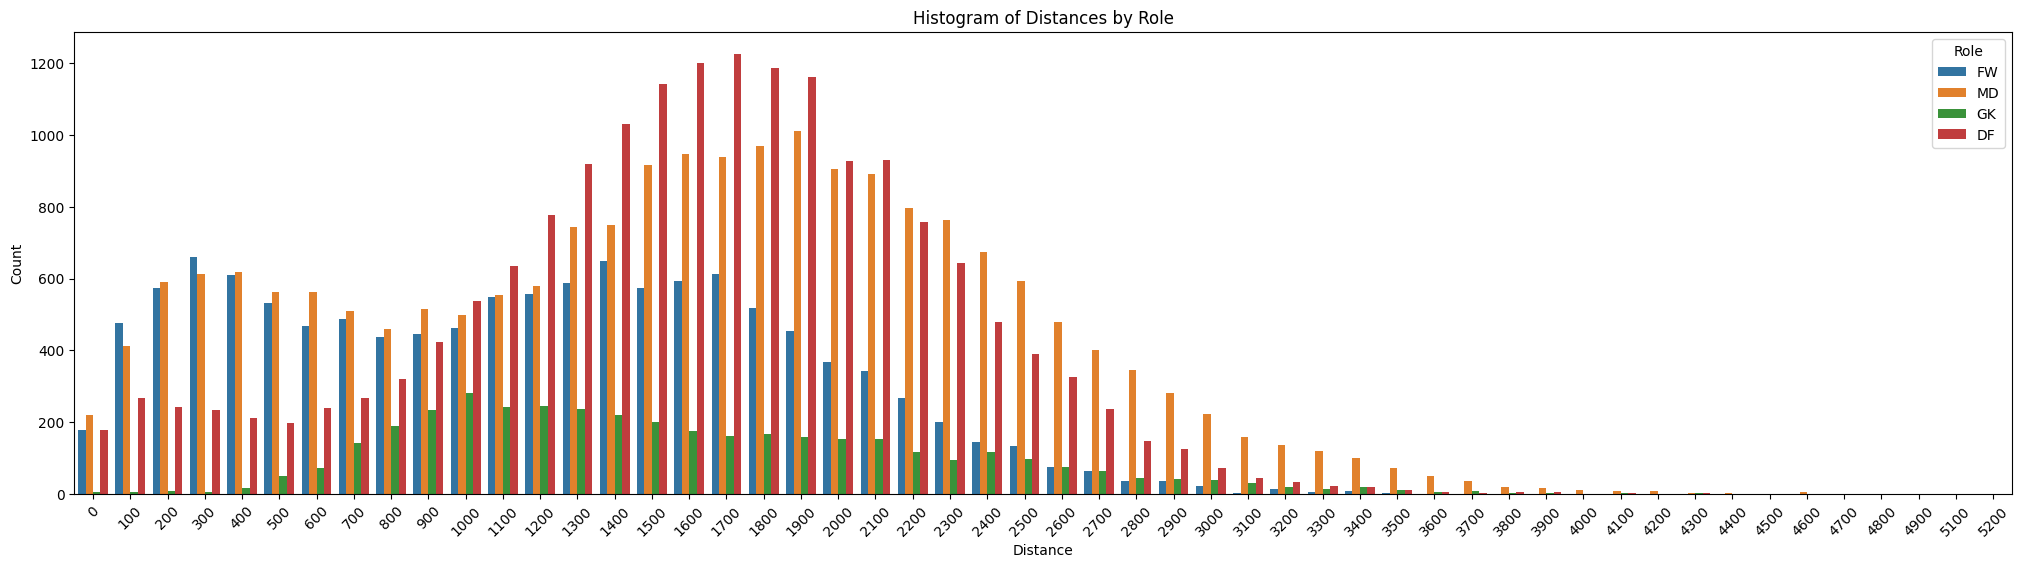

In [87]:
plot_histogram_per_role(players_role_distances_df)